# Projeto Final
**Disciplina:** Aprendizado Profundo para Processamento de Linguagem Natural

**Aluno:** Ismael Santana Silva

**Notebook disponível em:** https://colab.research.google.com/drive/1h3DIsZGS50TfwIkAAmLUdIZszwpX3Zlf?usp=sharing

**Dados utilizados neste projeto disponíveis em:** https://github.com/ismasantana/finalProjectNlp/

## Introdução


O objetivo deste projeto foi realizar um estudo do Aprendizado de Máquina para classificar texto como sendo escrito por pessoas com depressão ou sem depressão. Porém, ao invés de utilizar palavras como atributo para a classificação, foram utilizadas as POS tags das palavras do texto como atributo.

A ideia de utilizar essa abordagem foi para investigar se existem padrões gramaticais que podem identificar uma pessoa com depressão. Por exemplo, uma pessoa com depressão utiliza mais adjetivos do que pessoas uma pessoa que não está de depressão?

Neste trabalhos foram avaliados os classificados **Random Forest** e **Long Short Term Memory(LSTM)**.

## Coleta de dados

Para avaliação de classificadores automáticos na tarefa proposta, foram coletadas mensagens de fóruns do Reddit (https://www.reddit.com/). Foram selecionadas mensagens de fóruns que: (1) o assunto era sobre depressão, para formar o conjunto de mensagens de pessoas com depressão e (2) que os assuntos eram gerais, para formar um conjunto de mensagens que representa pessoas que não estão com depressão (ou grupo de controle).
- Os fóruns sobre depressão foram:
  - depression (https://www.reddit.com/r/depression/)
  - depression_help (https://www.reddit.com/r/depression_help/)
  - ForeverAlone (https://www.reddit.com/r/ForeverAlone/)
- Os fóruns sobre assuntos gerais foram:
  - Random_Acts_Of_Amazon (https://www.reddit.com/r/Random_Acts_Of_Amazon/)
  - news (https://www.reddit.com/r/news/)

Foi utilizado o script abaixo para coletar as mensagens dos fóruns supracitados:

In [ ]:
#https://praw.readthedocs.io/en/latest/getting_started/quick_start.html
!pip install praw
import praw
import sys

reddit = praw.Reddit(
     client_id="0nzFl2jzvYnLTQ",
     client_secret="JWfAyFGDn6qKC5NI4hzuFhf80kKQ2A",
     user_agent="script:nlp:Ismasantana",
     username="Ismasantana",
    password="nlpproject"
     
)
#Foruns coletados: depression, depression_help, Random_Acts_Of_Amazon, news,  ForeverAlone
forum = "depression" 
subreddit = reddit.subreddit(forum)

for submission in subreddit.hot(limit=100000):
    f =  open("comments_" + forum + ".txt", 'a', encoding='utf-8') 
    f.write('[${URL}] ' + submission.url + '\n')    # Output: the URL the submission points to
    f.write(submission.selftext.replace("\n", " ").strip() + '\n')
    submission.comments.replace_more(limit=None)        
    comments = submission.comments.list()
    
    for comment in comments:
        f.write(comment.body.replace("\n", " ").strip() + "\n")

## Pré-processamento dos dados

Importação das bibliotecas que são utilizadas no projeto e conexão com o Google drive para obtenção dos dados:

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

from google.colab import drive
 
drive.mount('/gdrive')

%cd /gdrive/'MyDrive'/NLP/ProjetoFinal

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /gdrive
/gdrive/MyDrive/NLP/ProjetoFinal


Criação da função `preprocess` para gerar as POS tags do texto:

In [ ]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

def preprocess(text): 
  text = text.translate(str.maketrans('', '', string.punctuation))
  
  text = re.sub('\W+',' ', text ).replace('  ', ' ').replace('—','')
  doc = nlp(text)

  return [(token.text,token.tag_)  for token in doc]

Função para ler o arquivo com as mensagens e gerar as POS tags com a função `preprocess`:

In [ ]:
def fillCorpus(corpus, file):
  print('Carregando:', file)
  # i = 0
  with open(file, 'r') as reader:
      # Read and print the entire file line by line
      line = reader.readline().strip().replace('\n','')
      while line != '':  # The EOF char is an empty string
        if '[${URL}]' not in line: 
          
          pos = preprocess(line)
          if len(pos) > 0:
            corpus.append([elem[1] for elem in pos if elem[1] not in ',:.'])
            
        line = reader.readline()

Chamada da função `fillCorpus` para gerar o conjunto de dados, composto de POS tags, que será utilizado neste projeto:

In [ ]:
from random import sample

corpusDepression = []
corpusControl = []
fillCorpus(corpusDepression, 'comments_depression.txt')
fillCorpus(corpusDepression, 'comments_depression_help.txt')
fillCorpus(corpusDepression, 'comments_ForeverAlone.txt')
fillCorpus(corpusControl, 'comments_news.txt')
fillCorpus(corpusControl, 'comments_Random_Acts_Of_Amazon.txt')

corpus = corpusDepression + corpusControl

Carregando: comments_depression.txt
Carregando: comments_depression_help.txt
Carregando: comments_ForeverAlone.txt
Carregando: comments_news.txt
Carregando: comments_Random_Acts_Of_Amazon.txt


Computando a frequencia de cada POS tag para nas sentenças para que essas frequencias sejam utilizadas com atributos para o Random Forest.

In [ ]:
from nltk import ngrams, FreqDist
keys = set()
countsCorpus = []
for c in corpus:
  counts = FreqDist(c)
  keys = keys.union(set(list(counts.keys())))
  countsCorpus.append(counts)

dataset = []
for counts in countsCorpus:
  record = []
  for k in keys:
    if k in counts:
      record.append(counts[k])
    else:
      record.append(0)
  dataset.append(record)


Gerando o vetor `y` com os labels dos dados: 

In [ ]:
pd.options.display.max_columns = None

y = [1 for i in range(len(corpusDepression))]
y = y + [0 for i in range(len(corpusControl))]

Salvando os dados pré-processados com os atributos sendo a frequência das POS tags em cada mensagem:

In [ ]:
df2 = pd.DataFrame(np.array(dataset).reshape(len(dataset),len(dataset[0])),
                   columns=keys)
df2['depression'] = y
df2.to_csv('pos_tag_frequencies.csv',index=False)

Sando as mensagens pré-processadas com cada palavra sendo substituida/representada por sua POS tag:

In [ ]:
with open('corpus-pos-tag', 'w+') as file:
  for i in range(len(corpus)):
    file.write('{},{}\n'.format(' '.join([str(elem) for elem in corpus[i] if elem not in ',.']), y[i]))

## Caracterização dos dados

Exemplo dos dados com atributos como a frequência das POS tags na mensagem:

In [ ]:
dataset = pd.read_csv('pos_tag_frequencies.csv')
dataset

,SYM,ADD,UH,NNP,NN,'',NFP,``,XX,LS,PRP,WDT,PRP$,JJS,WRB,JJR,-LRB-,FW,PDT,VBN,RB,VBG,CC,CD,RBR,DT,NNPS,VBP,MD,WP,VBD,-RRB-,RBS,RP,WP$,_SP,AFX,POS,VB,EX,TO,JJ,NNS,VBZ,$,IN,depression
0,0,0,1,8,113,0,0,0,0,0,31,1,21,5,8,12,0,0,0,10,63,14,36,2,3,68,0,34,7,9,1,0,0,2,1,0,0,0,53,1,29,55,54,26,0,104,1
1,0,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1
2,0,0,0,1,30,0,0,0,0,0,19,1,5,1,1,2,0,0,0,7,26,13,10,2,1,24,0,17,4,1,1,0,0,0,0,0,0,0,15,0,4,17,13,10,0,26,1
3,0,0,0,1,8,0,0,0,0,0,5,1,0,1,2,1,0,0,0,1,3,0,1,0,0,5,0,1,4,2,1,0,0,1,0,0,0,0,4,1,0,2,2,3,0,8,1
4,0,0,1,1,8,0,0,0,0,0,6,0,2,0,0,3,0,0,0,2,2,1,3,1,0,7,0,4,0,0,0,0,0,0,0,0,0,0,8,0,4,3,5,4,0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149089,0,0,1,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,2,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,2,0
149090,0,0,1,0,4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,3,1,2,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
149091,0,0,1,0,1,0,0,0,0,0,6,0,0,0,1,0,0,0,0,0,4,0,1,1,0,3,0,5,0,0,1,0,0,0,0,0,0,0,3,0,3,3,1,1,0,1,0
149092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Distribuição dos dados por classe (i.e., depressão ou controle):

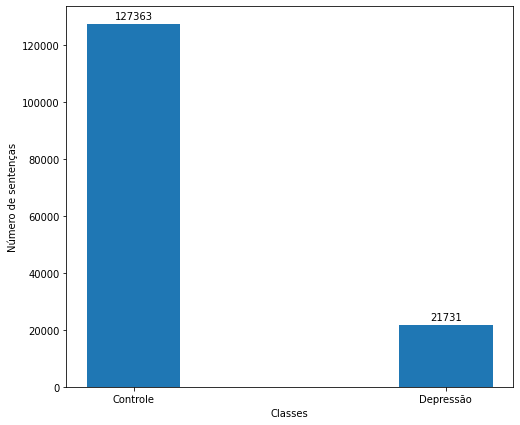

In [ ]:
#dataset['depression'].hist()
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (8,7)

fig, ax = plt.subplots()
#bar = plt.bar(df['tag'].tolist(), df['acc'].tolist())
bar = plt.bar(['Controle', 'Depressão'],dataset.groupby('depression').size().values,width=0.3)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar)
plt.ylabel('Número de sentenças')
plt.xlabel('Classes')
#plt.xticks(rotation = 70)
plt.show()

Frequencia das POS tags:

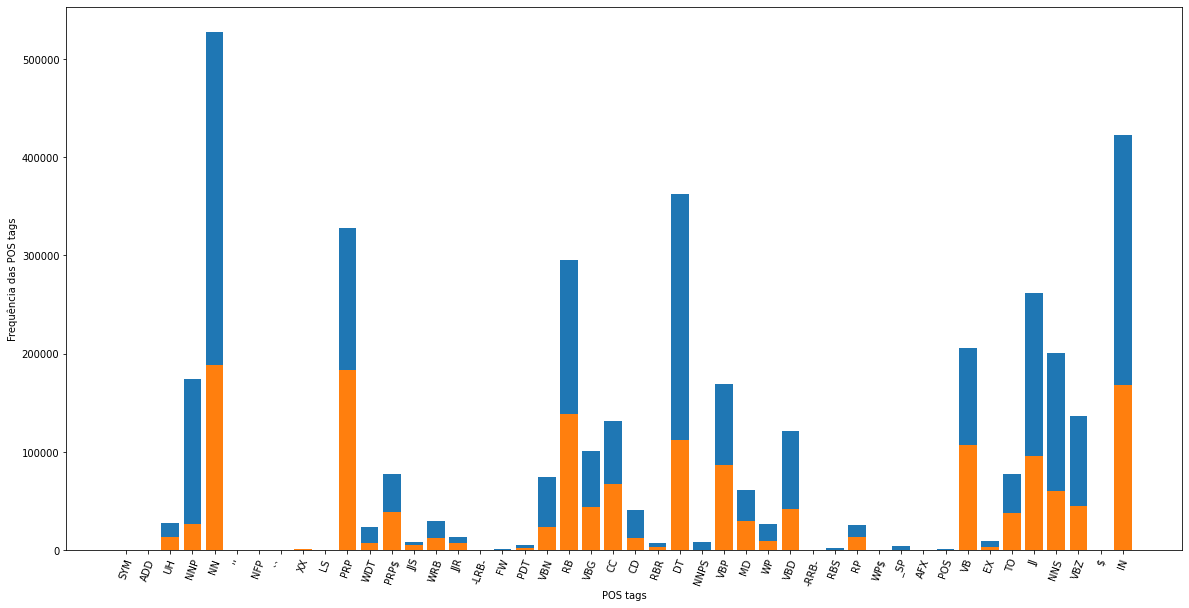

In [ ]:
#dataset['depression'].hist()
import matplotlib.pyplot as plt
import numpy as np

dfDepression = dataset[dataset['depression'] == 0].drop(columns=['depression'])
dfControl = dataset[dataset['depression'] == 1].drop(columns=['depression'])

plt.rcParams["figure.figsize"] = (20,10)

fig, ax = plt.subplots()
barDepression = plt.bar(dfDepression.columns,dfDepression.sum().values) #,width=0.3
barControl = plt.bar(dfControl.columns,dfControl.sum().values) #,width=0.3

plt.ylabel('Frequência das POS tags')
plt.xlabel('POS tags')
plt.xticks(rotation = 70)
plt.show()

Porcentagem de POS tags nas mensagens rotuladas como Depressão e Controle:

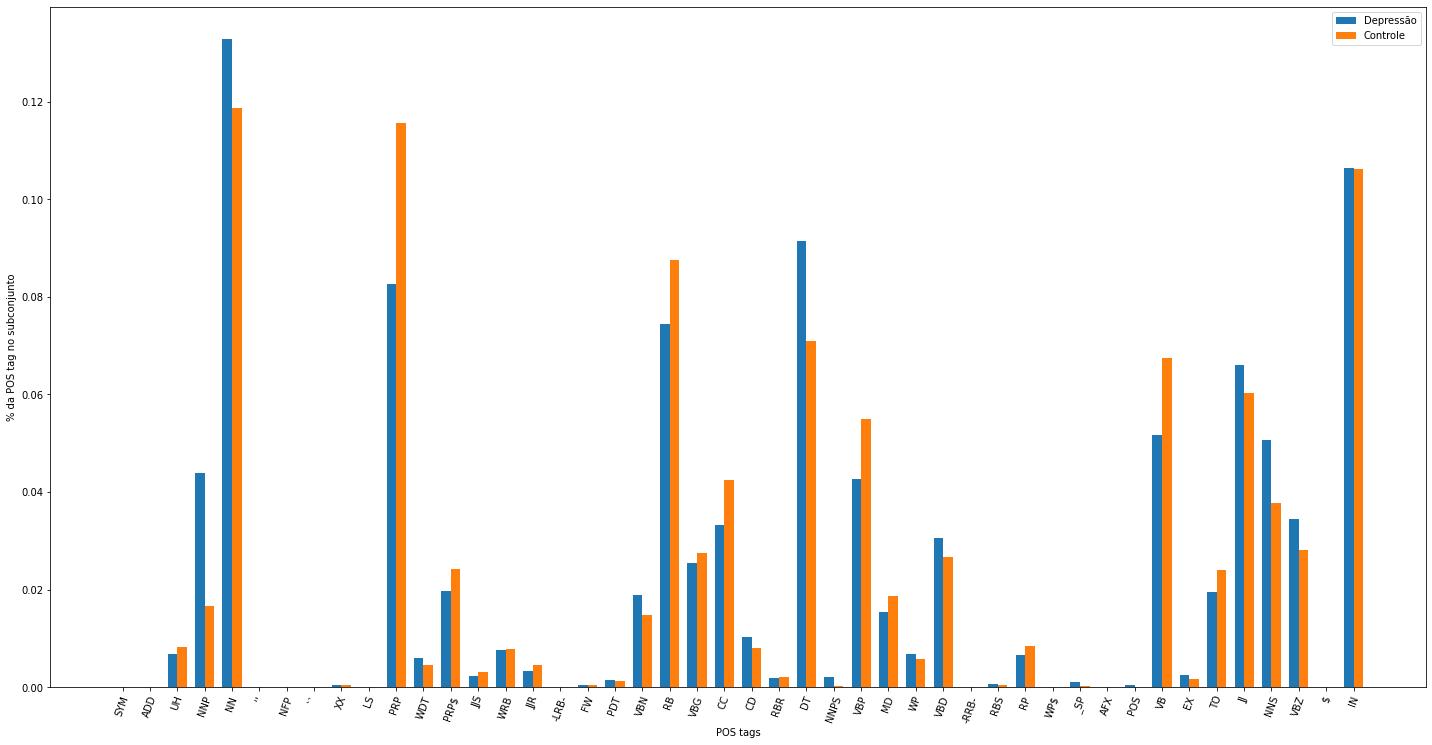

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(dfDepression.columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dfDepression.sum().values / dfDepression.sum().values.sum(), width, label='Depressão')
rects2 = ax.bar(x + width/2, dfControl.sum().values / dfControl.sum().values.sum(), width, label='Controle')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% da POS tag no subconjunto')
#ax.set_title('Porcentagens das POS tags em cada grupos')
ax.set_xticks(x)
ax.set_xticklabels(dfDepression.columns)
ax.legend()

fig.tight_layout()
plt.xlabel('POS tags')
plt.xticks(rotation = 70)
plt.show()

Diferença máxima:

In [ ]:
np.amax(
  (dfDepression.sum().values / dfDepression.sum().values.sum()) - 
  (dfControl.sum().values / dfControl.sum().values.sum()))

0.027282325873390238

Como pode ser observado não existe um grande diferença entre as porcentagens dad POS tags no dois subgrupos avalidos. A maior diferença foi observada para a POS tag PRP (Pronome pessoal) que é aproximadamente 3%.